/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python


=== TOP 10 OPTIMAL PORTFOLIOS ===
    Combination                                                        Weights  E(R) Portfolio  Std Portfolio  Sharpe Ratio
(KBC, REE, FPT)  [0.1147286222287499, 0.05000000000000001, 0.8352713777712502]        0.027335       0.087360         0.227
(KBC, MBB, FPT)                 [0.1132426982387414, 0.05, 0.8367573017612587]        0.027540       0.089060         0.225
(KBC, KDH, FPT) [0.10713533194574848, 0.05000000000000003, 0.8428646680542515]        0.027337       0.088289         0.225
(REE, KDH, FPT) [0.05000000000000003, 0.05000000000000006, 0.8999999999999999]        0.026746       0.088068         0.219
(REE, MBB, FPT)                               [0.05, 0.05, 0.9000000000000004]        0.026957       0.089079         0.218
(MBB, KDH, FPT)                [0.04999999999999999, 0.05, 0.8999999999999999]        0.026949       0.089748         0.217
(KBC, REE, MBB)  [0.5166569264295839, 0.20518806577337328, 0.2781550077970427]        0.021520   

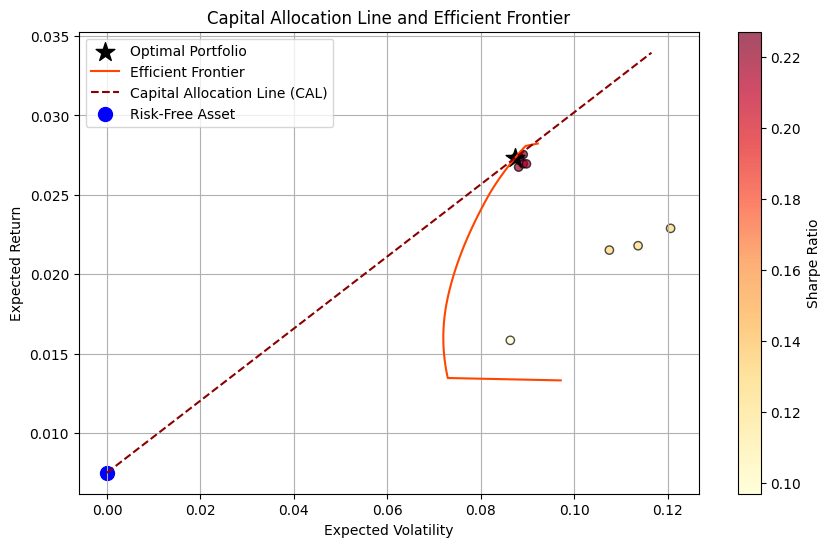


=== OPTIMAL PORTFOLIO RESULTS ===
    Combination                                                       Weights  E(R) Portfolio  Std Portfolio  Sharpe Ratio
(KBC, REE, FPT) [0.1147286222287499, 0.05000000000000001, 0.8352713777712502]        0.027335        0.08736         0.227


In [8]:
import numpy as np
from scipy.optimize import minimize
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Read the new Excel file
file_path = "/content/Filtered_PRICE.xlsx"
df = pd.read_excel(file_path)

# Check data
df.head()

# Convert the "Date" column to datetime format and set it as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Calculate monthly returns
returns = df.pct_change().dropna()

# Compute mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.0075  # Risk-free rate per month (9% per year)

# List of stock portfolio combinations (choosing 3 out of 5)
combinations = list(itertools.combinations(df.columns, 3))
results = []

# Sharpe ratio optimization function
def neg_sharpe(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - rf) / portfolio_std_dev
    return -sharpe  # Negative to maximize Sharpe ratio

# Optimize portfolio for each combination of 3 stocks
for combo in combinations:
    returns_subset = returns[list(combo)]
    num_assets = len(combo)

    # Random initial weights
    initial_weights = np.random.rand(num_assets)
    initial_weights /= np.sum(initial_weights)

    # Constraints and bounds
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0.05, 1) for _ in range(num_assets))

    # Optimization
    optimal_result = minimize(
        neg_sharpe, initial_weights, args=(mean_returns[list(combo)], returns_subset.cov()),
        method='SLSQP', bounds=bounds, constraints=constraints
    )

    # Store results
    optimal_weights = optimal_result.x
    sharpe = -optimal_result.fun
    expected_return = np.dot(optimal_weights, mean_returns[list(combo)])
    portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(returns_subset.cov(), optimal_weights)))

    results.append({
        'Combination': combo,
        'Weights': optimal_weights,
        'E(R) Portfolio': expected_return,
        'Std Portfolio': portfolio_std_dev,
        'Sharpe Ratio': round(sharpe,3)
    })

# Convert results to DataFrame and sort by Sharpe Ratio
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Sharpe Ratio', ascending=False).reset_index(drop=True)

# Select the optimal portfolio with the highest Sharpe Ratio
optimal_portfolio_combo = results_df.iloc[0]
optimal_weights = optimal_portfolio_combo['Weights']
optimal_return = np.dot(optimal_weights, mean_returns[list(optimal_portfolio_combo['Combination'])])
optimal_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(returns[list(optimal_portfolio_combo['Combination'])].cov(), optimal_weights)))

# Get the top 10 portfolios with the highest Sharpe Ratios
top_10_portfolios = results_df.head(10)

# Print results
print("\n=== TOP 10 OPTIMAL PORTFOLIOS ===")
print(top_10_portfolios.to_string(index=False))

# Output results
optimal_portfolio_combo, optimal_weights, optimal_return, optimal_risk

# Function to calculate portfolio standard deviation
def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to minimize risk for a given target return
def minimize_risk(target_return, returns, cov_matrix):
    num_assets = len(returns)
    args = (cov_matrix,)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, returns) - target_return}
    ]

    bounds = [(0, 1) for _ in range(num_assets)]
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(portfolio_std, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.fun

# Input data
expected_returns = returns.mean().values
cov_matrix = returns.cov().values

# Generate points on the Efficient Frontier
target_returns = np.linspace(min(expected_returns), max(expected_returns), 100)
efficient_risks = [minimize_risk(r, expected_returns, cov_matrix) for r in target_returns]

# Portfolio data
portfolio_returns = results_df['E(R) Portfolio']
portfolio_risks = results_df['Std Portfolio']
sharpe_ratios = results_df['Sharpe Ratio']

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
scatter = plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap="YlOrRd", edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label='Sharpe Ratio')

# Plot optimal portfolio
plt.scatter(optimal_risk, optimal_return, marker='*', color='black', s=200, label='Optimal Portfolio')

# Plot Efficient Frontier line
plt.plot(efficient_risks, target_returns, linestyle='-', color='orangered', label='Efficient Frontier')

# Plot Capital Allocation Line (CAL)
sigma_values = np.linspace(0, max(efficient_risks) * 1.2, 100)
cal_line = rf + (optimal_return - rf) / optimal_risk * sigma_values
plt.plot(sigma_values, cal_line, 'darkred', linestyle='--', label='Capital Allocation Line (CAL)')

# Plot risk-free asset
plt.scatter(0, rf, color='blue', marker='o', s=100, label='Risk-Free Asset')

# Labels & Legend
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Capital Allocation Line and Efficient Frontier')
plt.legend()
plt.grid()
plt.show()

# Create DataFrame for optimal portfolio results
optimal_df = pd.DataFrame({
    "Combination": [optimal_portfolio_combo['Combination']],
    "Weights": [optimal_weights.tolist()],
    "E(R) Portfolio": [optimal_return],
    "Std Portfolio": [optimal_risk],
    "Sharpe Ratio": [optimal_portfolio_combo['Sharpe Ratio']]
})

# Print results
print("\n=== OPTIMAL PORTFOLIO RESULTS ===")
print(optimal_df.to_string(index=False))